**Chapter 14 – Deep Computer Vision Using Convolutional Neural Networks**

_This notebook contains all the sample code and solutions to the exercises in chapter 14._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml3/blob/main/14_deep_computer_vision_with_cnns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml3/blob/main/14_deep_computer_vision_with_cnns.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

This project requires Python 3.7 or above:

In [1]:
import sys

assert sys.version_info >= (3, 7)

It also requires Scikit-Learn ≥ 1.0.1:

In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

And TensorFlow ≥ 2.8:

In [3]:
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

As we did in earlier chapters, let's define the default font sizes to make the figures prettier:

In [4]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

This chapter can be very slow without a GPU, so let's make sure there's one, or else issue a warning:

In [5]:
# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Convolutional Layers
## Implementing Convolutional Layers With Keras

Let's load two sample images, rescale their pixel values to 0-1, and center crop them to small 70×120 images:

In [6]:
from sklearn.datasets import load_sample_images
import tensorflow as tf

images = load_sample_images()["images"]
images = tf.keras.layers.CenterCrop(height=70, width=120)(images)
images = tf.keras.layers.Rescaling(scale=1 / 255)(images)

In [7]:
images.shape

TensorShape([2, 70, 120, 3])

In [8]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7)
fmaps = conv_layer(images)

In [9]:
fmaps.shape

TensorShape([2, 64, 114, 32])

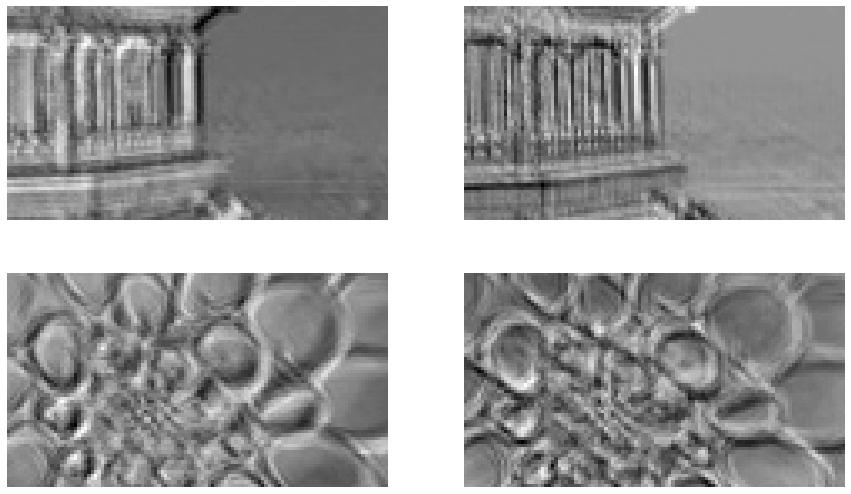

In [10]:
# extra code – displays the two output feature maps for each image

plt.figure(figsize=(15, 9))
for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

As you can see, randomly generated filters typically act like edge detectors, which is great since that's a useful tool in image processing, and that's the type of filters that a convolutional layer typically starts with. Then, during training, it gradually learns improved filters to recognize useful patterns for the task.

Now let's use zero-padding:

In [11]:
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7,
                                    padding="same")
fmaps = conv_layer(images)

In [12]:
fmaps.shape

TensorShape([2, 70, 120, 32])

In [13]:
# extra code – shows that the output shape when we set strides=2
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7, padding="same",
                                    strides=2)
fmaps = conv_layer(images)
fmaps.shape

TensorShape([2, 35, 60, 32])

In [14]:
# extra code – this utility function can be useful to compute the size of the
#              feature maps output by a convolutional layer. It also returns
#              the number of ignored rows or columns if padding="valid", or the
#              number of zero-padded rows or columns if padding="same"."""

import numpy as np

def conv_output_size(input_size, kernel_size, strides=1, padding="valid"):
    if padding=="valid":
        z = input_size - kernel_size + strides
        output_size = z // strides
        num_ignored = z % strides
        return output_size, num_ignored
    else:
        output_size = (input_size - 1) // strides + 1
        num_padded = (output_size - 1) * strides + kernel_size - input_size
        return output_size, num_padded

conv_output_size(np.array([70, 120]), kernel_size=7, strides=2, padding="same")

(array([35, 60]), array([5, 5]))

Let's now look at the weights:

In [15]:
kernels, biases = conv_layer.get_weights()
kernels.shape

(7, 7, 3, 32)

In [16]:
biases.shape

(32,)

In [17]:
# extra code – shows how to use the tf.nn.conv2d() operation

tf.random.set_seed(42)
filters = tf.random.normal([7, 7, 3, 2])
biases = tf.zeros([2])
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases

Let's manually create two filters full of zeros, except for a vertical line of 1s in the first filter, and a horizontal one in the second filter (just like in Figure 14–5). The two output feature maps highlight vertical lines and horizontal lines, respectively. In practice you will probably never need to create filters manually, since the convolutional layers will learn them automatically.

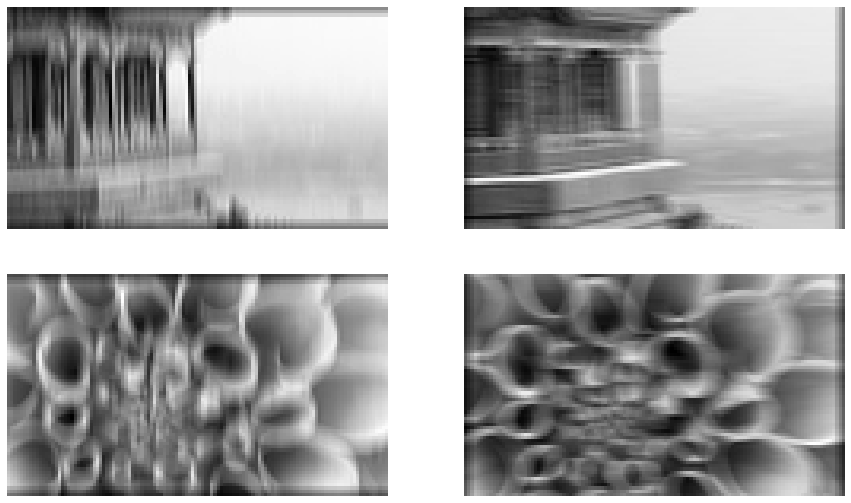

In [18]:
# extra code – shows how to manually create two filters to get images similar
#              to those in Figure 14–5.

plt.figure(figsize=(15, 9))
filters = np.zeros([7, 7, 3, 2])
filters[:, 3, :, 0] = 1
filters[3, :, :, 1] = 1
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases

for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

Notice the dark lines at the top and bottom of the two images on the left, and on the left and right of the two images on the right? Can you guess what these are? Why were they not present in the previous figure?

You guessed it! These are artifacts due to the fact that we used zero padding in this case, while we did not use zero padding to create the feature maps in the previous figure. Because of zero padding, the two feature maps based on the vertical line filter (i.e., the two left images) could not fully activate near the top and bottom of the images. Similarly, the two feature maps based on the horizontal line filter (i.e., the two right images) could not fully activate near the left and right of the images.

# Pooling Layers
## Implementing Pooling Layers With Keras

**Max pooling**

In [19]:
max_pool = tf.keras.layers.MaxPool2D(pool_size=2)

In [20]:
output = max_pool(images)

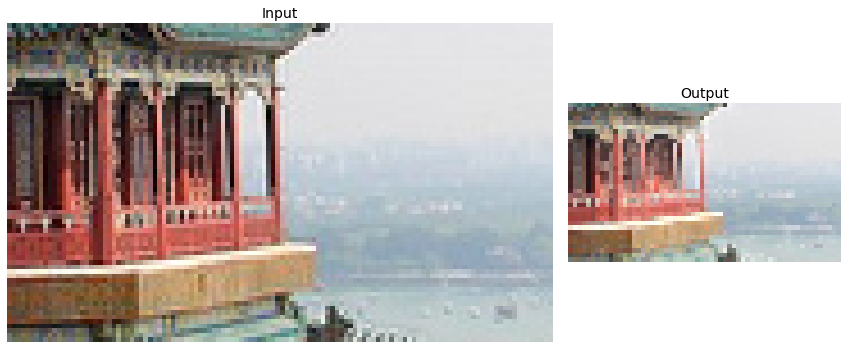

In [21]:
# extra code – this cells shows what max pooling with stride = 2 looks like

import matplotlib as mpl

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input")
ax1.imshow(images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output")
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

**Depth-wise pooling**

In [22]:
# extra code – shows how to use the max_pool() op; only works on the CPU
np.random.seed(42)
fmaps = np.random.rand(2, 70, 120, 60)
with tf.device("/cpu:0"):
    output = tf.nn.max_pool(fmaps, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3),
                            padding="VALID")
output.shape

TensorShape([2, 70, 120, 20])

In [23]:
class DepthPool(tf.keras.layers.Layer):
    def __init__(self, pool_size=2, **kwargs):
        super().__init__(**kwargs)
        self.pool_size = pool_size
    
    def call(self, inputs):
        shape = tf.shape(inputs)  # shape[-1] is the number of channels
        groups = shape[-1] // self.pool_size  # number of channel groups
        new_shape = tf.concat([shape[:-1], [groups, self.pool_size]], axis=0)
        return tf.reduce_max(tf.reshape(inputs, new_shape), axis=-1)

In [24]:
# extra code – shows that this custom layer gives the same result as max_pool()
np.allclose(DepthPool(pool_size=3)(fmaps), output)

True

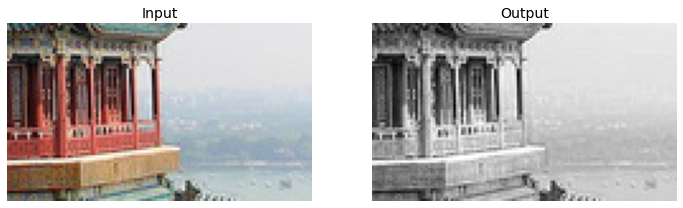

In [25]:
# extra code – computes and displays the output of the depthwise pooling layer

depth_output = DepthPool(pool_size=3)(images)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input")
plt.imshow(images[0])  # plot the 1st image
plt.axis("off")
plt.subplot(1, 2, 2)
plt.title("Output")
plt.imshow(depth_output[0, ..., 0], cmap="gray")  # plot 1st image's output
plt.axis("off")
plt.show()

**Global Average Pooling**

In [26]:
global_avg_pool = tf.keras.layers.GlobalAvgPool2D()

The following layer is equivalent:

In [27]:
global_avg_pool = tf.keras.layers.Lambda(
    lambda X: tf.reduce_mean(X, axis=[1, 2]))

In [28]:
global_avg_pool(images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.643388  , 0.59718215, 0.5825038 ],
       [0.7630747 , 0.2601088 , 0.10848834]], dtype=float32)>

# CNN Architectures

**Tackling Fashion MNIST With a CNN**

In [29]:
# extra code – loads the mnist dataset, add the channels axis to the inputs,
#              scales the values to the 0-1 range, and splits the dataset
mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = mnist
X_train_full = np.expand_dims(X_train_full, axis=-1).astype(np.float32) / 255
X_test = np.expand_dims(X_test.astype(np.float32), axis=-1) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

4431872/4422102 [==============================] - 0s 0us/step


In [30]:
from functools import partial

tf.random.set_seed(42)  # extra code – ensures reproducibility
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same",
                        activation="relu", kernel_initializer="he_normal")
model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=10, activation="softmax")
])

In [31]:
# extra code – compiles, fits, evaluates, and uses the model to make predictions
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10]  # pretend we have new images
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 [==============================] - 53s 28ms/step - loss: 0.7001 - accuracy: 0.7601 - val_loss: 0.3433 - val_accuracy: 0.8764
Epoch 2/10
1719/1719 [==============================] - 37s 21ms/step - loss: 0.3948 - accuracy: 0.8662 - val_loss: 0.3217 - val_accuracy: 0.8816
Epoch 3/10
1719/1719 [==============================] - 37s 22ms/step - loss: 0.3339 - accuracy: 0.8867 - val_loss: 0.3310 - val_accuracy: 0.8918
Epoch 4/10
1719/1719 [==============================] - 37s 22ms/step - loss: 0.2979 - accuracy: 0.9003 - val_loss: 0.2454 - val_accuracy: 0.9072
Epoch 5/10
1719/1719 [==============================] - 37s 21ms/step - loss: 0.2756 - accuracy: 0.9070 - val_loss: 0.2477 - val_accuracy: 0.9120
Epoch 6/10
1719/1719 [==============================] - 36s 21ms/step - loss: 0.2580 - accuracy: 0.9129 - val_loss: 0.2774 - val_accuracy: 0.9028
Epoch 7/10
1719/1719 [==============================] - 37s 21ms/step - loss: 0.2432 - accuracy: 0.9169 - val_loss: 0.2824 -

## LeNet-5

The famous LeNet-5 architecture had the following layers:

Layer  | Type            | Maps | Size     | Kernel size | Stride | Activation
-------|-----------------|------|----------|-------------|--------|-----------
 Out   | Fully connected | –    | 10       | –           | –      | RBF
 F6    | Fully connected | –    | 84       | –           | –      | tanh
 C5    | Convolution     | 120  | 1 × 1    | 5 × 5       | 1      | tanh
 S4    | Avg pooling     | 16   | 5 × 5    | 2 × 2       | 2      | tanh
 C3    | Convolution     | 16   | 10 × 10  | 5 × 5       | 1      | tanh
 S2    | Avg pooling     | 6    | 14 × 14  | 2 × 2       | 2      | tanh
 C1    | Convolution     | 6    | 28 × 28  | 5 × 5       | 1      | tanh
 In    | Input           | 1    | 32 × 32  | –           | –      | –

There were a few tweaks here and there, which don't really matter much anymore, but in case you are interested, here they are:

* MNIST images are 28 × 28 pixels, but they are zero-padded to 32 × 32 pixels and normalized before being fed to the network. The rest of the network does not use any padding, which is why the size keeps shrinking as the image progresses through the network.
* The average pooling layers are slightly more complex than usual: each neuron computes the mean of its inputs, then multiplies the result by a learnable coefficient (one per map) and adds a learnable bias term (again, one per map), then finally applies the activation function.
* Most neurons in C3 maps are connected to neurons in only three or four S2 maps (instead of all six S2 maps). See table 1 (page 8) in the [original paper](https://homl.info/lenet5) for details.
* The output layer is a bit special: instead of computing the matrix multiplication of the inputs and the weight vector, each neuron outputs the square of the Euclidian distance between its input vector and its weight vector. Each output measures how much the image belongs to a particular digit class. The cross-entropy cost function is now preferred, as it penalizes bad predictions much more, producing larger gradients and converging faster.

# Implementing a ResNet-34 CNN Using Keras

In [32]:
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="same", kernel_initializer="he_normal",
                        use_bias=False)

class ResidualUnit(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            tf.keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            tf.keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                tf.keras.layers.BatchNormalization()
            ]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [33]:
model = tf.keras.Sequential([
    DefaultConv2D(64, kernel_size=7, strides=2, input_shape=[224, 224, 3]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"),
])
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters

model.add(tf.keras.layers.GlobalAvgPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10, activation="softmax"))

# Using Pretrained Models from Keras

In [34]:
model = tf.keras.applications.ResNet50(weights="imagenet")

102981632/102967424 [==============================] - 1s 0us/step


**Warning**: The expression `load_sample_images()["images"]` returns a Python list of images. However, in the latest versions, Keras does not accept Python lists anymore, so we must convert this list to a tensor. We can do this using `tf.constant()`, but here I have used `K.constant()` instead: it simply calls `tf.constant()` if you are using TensorFlow as the backend (as is the case here), but if you ever decide to use JAX or PyTorch as the backend instead, `K.constant()` will call the appropriate function from the chosen backend.

In [35]:
K = tf.keras.backend
images = K.constant(load_sample_images()["images"])
images_resized = tf.keras.layers.Resizing(height=224, width=224,
                                          crop_to_aspect_ratio=True)(images)

In [36]:
inputs = tf.keras.applications.resnet50.preprocess_input(images_resized)

In [37]:
Y_proba = model.predict(inputs)
Y_proba.shape

(2, 1000)

In [38]:
top_K = tf.keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print(f"Image #{image_index}")
    for class_id, name, y_proba in top_K[image_index]:
        print(f"  {class_id} - {name:12s} {y_proba:.2%}")

49152/35363 [=========================================] - 0s 0us/step
Image #0
  n03877845 - palace       54.69%
  n03781244 - monastery    24.72%
  n02825657 - bell_cote    18.55%
Image #1
  n04522168 - vase         32.66%
  n11939491 - daisy        17.81%
  n03530642 - honeycomb    12.06%


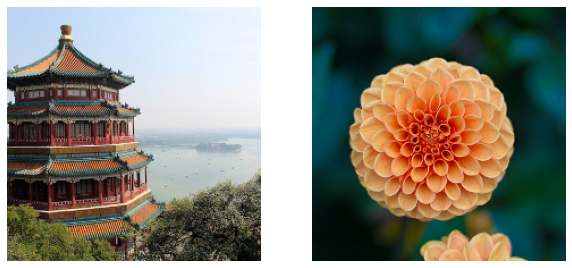

In [39]:
# extra code – displays the cropped and resized images

plt.figure(figsize=(10, 6))
for idx in (0, 1):
    plt.subplot(1, 2, idx + 1)
    plt.imshow(images_resized[idx] / 255)
    plt.axis("off")

plt.show()

# Pretrained Models for Transfer Learning

In [40]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]


Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [41]:
dataset_size

3670

In [42]:
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [43]:
n_classes

5

In [44]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

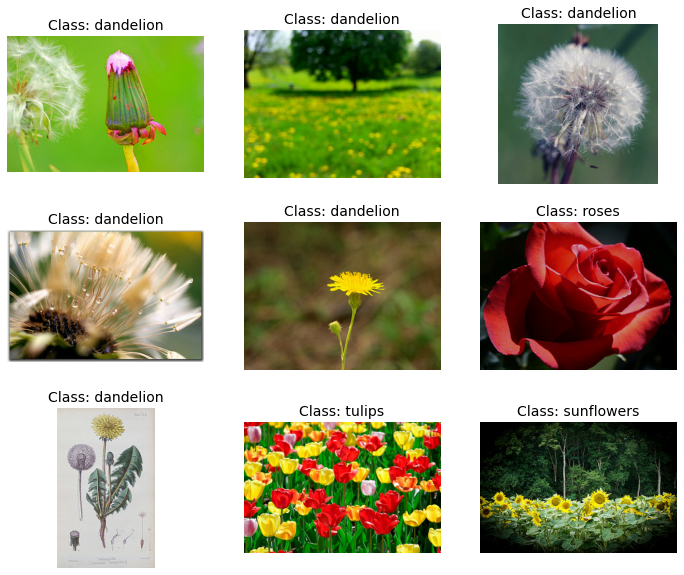

In [45]:
# extra code – displays the first 9 images in the validation set

plt.figure(figsize=(12, 10))
index = 0
for image, label in valid_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title(f"Class: {class_names[label]}")
    plt.axis("off")

plt.show()

All three datasets contain individual images. We need to batch them, but for this we first need to ensure they all have the same size, or else batching will not work. We can use a `Resizing` layer for this. We must also call the `tf.keras.applications.xception.preprocess_input()` function to preprocess the images appropriately for the Xception model. We will also add shuffling and prefetching to the training dataset.

In [46]:
tf.keras.backend.clear_session()  # extra code – resets layer name counter

batch_size = 32
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])
train_set = train_set_raw.map(lambda X, y: (preprocess(X), y))
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)

Let's take a look again at the first 9 images from the validation set: they're all 224x224 now, with values ranging from -1 to 1:

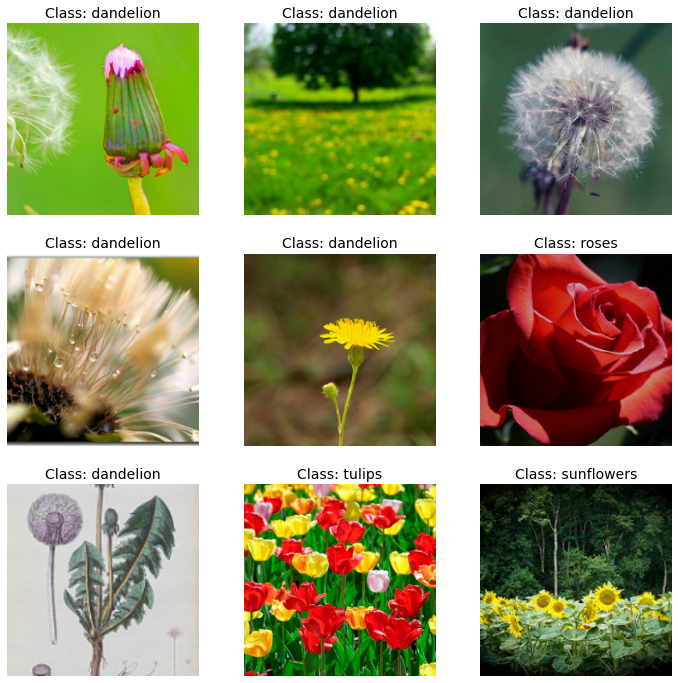

In [47]:
# extra code – displays the first 9 images in the first batch of valid_set

plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow((X_batch[index] + 1) / 2)  # rescale to 0–1 for imshow()
        plt.title(f"Class: {class_names[y_batch[index]]}")
        plt.axis("off")

plt.show()

In [48]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
    tf.keras.layers.RandomRotation(factor=0.05, seed=42),
    tf.keras.layers.RandomContrast(factor=0.2, seed=42)
])

Try running the following cell multiple times to see different random data augmentations:

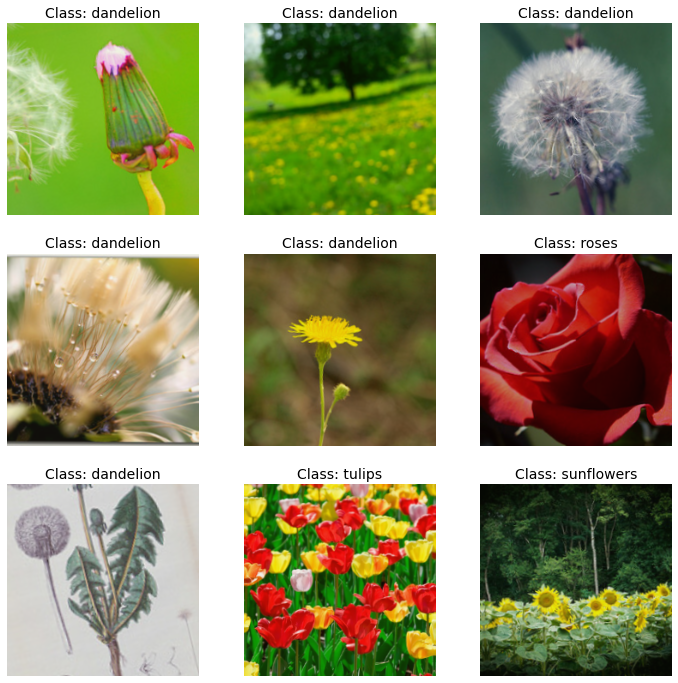

In [49]:
# extra code – displays the same first 9 images, after augmentation

plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    X_batch_augmented = data_augmentation(X_batch, training=True)
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        # We must rescale the images to the 0-1 range for imshow(), and also
        # clip the result to that range, because data augmentation may
        # make some values go out of bounds (e.g., RandomContrast in this case).
        plt.imshow(np.clip((X_batch_augmented[index] + 1) / 2, 0, 1))
        plt.title(f"Class: {class_names[y_batch[index]]}")
        plt.axis("off")

plt.show()

Now let's load the pretrained model, without its top layers, and replace them with our own, for the flower classification task:

In [50]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

83697664/83683744 [==============================] - 1s 0us/step


In [51]:
for layer in base_model.layers:
    layer.trainable = False

Let's train the model for a few epochs, while keeping the base model weights fixed:

In [52]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=3)

Epoch 1/3
86/86 [==============================] - 42s 417ms/step - loss: 0.7492 - accuracy: 0.8052 - val_loss: 0.6932 - val_accuracy: 0.8421
Epoch 2/3
86/86 [==============================] - 35s 393ms/step - loss: 0.3207 - accuracy: 0.9084 - val_loss: 0.6522 - val_accuracy: 0.8312
Epoch 3/3
86/86 [==============================] - 35s 393ms/step - loss: 0.1766 - accuracy: 0.9415 - val_loss: 0.7004 - val_accuracy: 0.8475


In [53]:
for indices in zip(range(33), range(33, 66), range(66, 99), range(99, 132)):
    for idx in indices:
        print(f"{idx:3}: {base_model.layers[idx].name:22}", end="")
    print()

  0: input_1                33: block4_pool            66: block8_sepconv1_act    99: block11_sepconv2_act  
  1: block1_conv1           34: batch_normalization_2  67: block8_sepconv1       100: block11_sepconv2      
  2: block1_conv1_bn        35: add_2                  68: block8_sepconv1_bn    101: block11_sepconv2_bn   
  3: block1_conv1_act       36: block5_sepconv1_act    69: block8_sepconv2_act   102: block11_sepconv3_act  
  4: block1_conv2           37: block5_sepconv1        70: block8_sepconv2       103: block11_sepconv3      
  5: block1_conv2_bn        38: block5_sepconv1_bn     71: block8_sepconv2_bn    104: block11_sepconv3_bn   
  6: block1_conv2_act       39: block5_sepconv2_act    72: block8_sepconv3_act   105: add_9                 
  7: block2_sepconv1        40: block5_sepconv2        73: block8_sepconv3       106: block12_sepconv1_act  
  8: block2_sepconv1_bn     41: block5_sepconv2_bn     74: block8_sepconv3_bn    107: block12_sepconv1      
  9: block2_sepconv

Now that the weights of our new top layers are not too bad, we can make the top part of the base model trainable again, and continue training, but with a lower learning rate:

In [54]:
for layer in base_model.layers[56:]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=10)

Epoch 1/10
86/86 [==============================] - 72s 779ms/step - loss: 0.2921 - accuracy: 0.9117 - val_loss: 0.4541 - val_accuracy: 0.8711
Epoch 2/10
86/86 [==============================] - 67s 767ms/step - loss: 0.0382 - accuracy: 0.9876 - val_loss: 0.3715 - val_accuracy: 0.9074
Epoch 3/10
86/86 [==============================] - 67s 765ms/step - loss: 0.0140 - accuracy: 0.9956 - val_loss: 0.3679 - val_accuracy: 0.9038
Epoch 4/10
86/86 [==============================] - 67s 766ms/step - loss: 0.0167 - accuracy: 0.9945 - val_loss: 0.3298 - val_accuracy: 0.9020
Epoch 5/10
86/86 [==============================] - 67s 767ms/step - loss: 0.0090 - accuracy: 0.9971 - val_loss: 0.3876 - val_accuracy: 0.8984
Epoch 6/10
86/86 [==============================] - 67s 765ms/step - loss: 0.0044 - accuracy: 0.9985 - val_loss: 0.3708 - val_accuracy: 0.9038
Epoch 7/10
86/86 [==============================] - 67s 765ms/step - loss: 0.0029 - accuracy: 0.9996 - val_loss: 0.3535 - val_accuracy: 0.9147

# Classification and Localization

**Note**: the code below used to reuse the optimizer from the previous model. This was fine in earlier versions of TensorFlow, but in more recent versions it can cause some issues, so I added a line to create a new optimizer here. Also, recent versions of Keras expect one metric per output, so I added the `"mse"` metric to the list.

In [55]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = tf.keras.layers.Dense(4)(avg)
model = tf.keras.Model(inputs=base_model.input,
                       outputs=[class_output, loc_output])
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)  # added this line
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2],  # depends on what you care most about
              optimizer=optimizer, metrics=["accuracy", "mse"])

In [56]:
# extra code – fits the model using random target bounding boxes (in real life
#              you would need to create proper targets instead)

def add_random_bounding_boxes(images, labels):
    fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4])
    return images, (labels, fake_bboxes)

fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)
model.fit(fake_train_set, epochs=2)

Epoch 1/2
10/10 [==============================] - 22s 1s/step - loss: 1.2157 - dense_1_loss: 1.4583 - dense_2_loss: 0.2450 - dense_1_accuracy: 0.4219 - dense_2_accuracy: 0.2594
Epoch 2/2
10/10 [==============================] - 15s 1s/step - loss: 0.7974 - dense_1_loss: 0.9474 - dense_2_loss: 0.1972 - dense_1_accuracy: 0.7594 - dense_2_accuracy: 0.2812


# Extra Material – How mAP Relates to Precision/Recall

In [57]:
def maximum_precisions(precisions):
    return np.flip(np.maximum.accumulate(np.flip(precisions)))

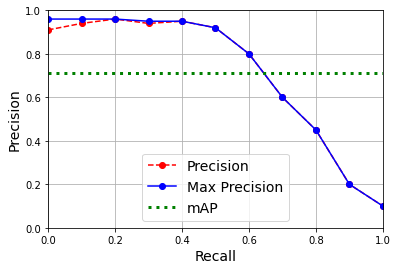

In [58]:
recalls = np.linspace(0, 1, 11)

precisions = [0.91, 0.94, 0.96, 0.94, 0.95, 0.92, 0.80, 0.60, 0.45, 0.20, 0.10]
max_precisions = maximum_precisions(precisions)
mAP = max_precisions.mean()
plt.plot(recalls, precisions, "ro--", label="Precision")
plt.plot(recalls, max_precisions, "bo-", label="Max Precision")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot([0, 1], [mAP, mAP], "g:", linewidth=3, label="mAP")
plt.grid(True)
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower center")
plt.show()

# Exercises

## 1. to 8.

1. These are the main advantages of a CNN over a fully connected DNN for image classification:
    * Because consecutive layers are only partially connected and because it heavily reuses its weights, a CNN has many fewer parameters than a fully connected DNN, which makes it much faster to train, reduces the risk of overfitting, and requires much less training data.
    * When a CNN has learned a kernel that can detect a particular feature, it can detect that feature anywhere in the image. In contrast, when a DNN learns a feature in one location, it can detect it only in that particular location. Since images typically have very repetitive features, CNNs are able to generalize much better than DNNs for image processing tasks such as classification, using fewer training examples.
    * Finally, a DNN has no prior knowledge of how pixels are organized; it does not know that nearby pixels are close. A CNN's architecture embeds this prior knowledge. Lower layers typically identify features in small areas of the images, while higher layers combine the lower-level features into larger features. This works well with most natural images, giving CNNs a decisive head start compared to DNNs.
2. Let's compute how many parameters the CNN has.
    * Since its first convolutional layer has 3 × 3 kernels, and the input has three channels (red, green, and blue), each feature map has 3 × 3 × 3 weights, plus a bias term. That's 28 parameters per feature map. Since this first convolutional layer has 100 feature maps, it has a total of 2,800 parameters. The second convolutional layer has 3 × 3 kernels and its input is the set of 100 feature maps of the previous layer, so each feature map has 3 × 3 × 100 = 900 weights, plus a bias term. Since it has 200 feature maps, this layer has 901 × 200 = 180,200 parameters. Finally, the third and last convolutional layer also has 3 × 3 kernels, and its input is the set of 200 feature maps of the previous layers, so each feature map has 3 × 3 × 200 = 1,800 weights, plus a bias term. Since it has 400 feature maps, this layer has a total of 1,801 × 400 = 720,400 parameters. All in all, the CNN has 2,800 + 180,200 + 720,400 =  903,400 parameters.<br/>
    * Now let's compute how much RAM this neural network will require (at least) when making a prediction for a single instance. First let's compute the feature map size for each layer. Since we are using a stride of 2 and `"same"` padding, the horizontal and vertical dimensions of the feature maps are divided by 2 at each layer (rounding up if necessary). So, as the input channels are 200 × 300 pixels, the first layer's feature maps are 100 × 150, the second layer's feature maps are 50 × 75, and the third layer's feature maps are 25 × 38. Since 32 bits is 4 bytes and the first convolutional layer has 100 feature maps, this first layer takes up 4 × 100 × 150 × 100 = 6 million bytes (6 MB). The second layer takes up 4 × 50 × 75 × 200 = 3 million bytes (3 MB). Finally, the third layer takes up 4 × 25 × 38 × 400 = 1,520,000 bytes (about 1.5 MB). However, once a layer has been computed, the memory occupied by the previous layer can be released, so if everything is well optimized, only 6 + 3 = 9 million bytes (9 MB) of RAM will be required (when the second layer has just been computed, but the memory occupied by the first layer has not been released yet). But wait, you also need to add the memory occupied by the CNN's parameters! We computed earlier that it has 903,400 parameters, each using up 4 bytes, so this adds 3,613,600 bytes (about 3.6 MB). The total RAM required is therefore (at least) 12,613,600 bytes (about 12.6 MB).<br/>
    * Lastly, let's compute the minimum amount of RAM required when training the CNN on a mini-batch of 50 images. During training TensorFlow uses backpropagation, which requires keeping all values computed during the forward pass until the reverse pass begins. So we must compute the total RAM required by all layers for a single instance and multiply that by 50. At this point, let's start counting in megabytes rather than bytes. We computed before that the three layers require respectively 6, 3, and 1.5 MB for each instance. That's a total of 10.5 MB per instance, so for 50 instances the total RAM required is 525 MB. Add to that the RAM required by the input images, which is 50 × 4 × 200 × 300 × 3 = 36 million bytes (36 MB), plus the RAM required for the model parameters, which is about 3.6 MB (computed earlier), plus some RAM for the gradients (we will neglect this since it can be released gradually as backpropagation goes down the layers during the reverse pass). We are up to a total of roughly 525 + 36 + 3.6 = 564.6 MB, and that's really an optimistic bare minimum.
3. If your GPU runs out of memory while training a CNN, here are five things you could try to solve the problem (other than purchasing a GPU with more RAM):
    * Reduce the mini-batch size.
    * Reduce dimensionality using a larger stride in one or more layers.
    * Remove one or more layers.
    * Use 16-bit floats instead of 32-bit floats.
    * Distribute the CNN across multiple devices.
4. A max pooling layer has no parameters at all, whereas a convolutional layer has quite a few (see the previous questions).
5. A local response normalization layer makes the neurons that most strongly activate inhibit neurons at the same location but in neighboring feature maps, which encourages different feature maps to specialize and pushes them apart, forcing them to explore a wider range of features. It is typically used in the lower layers to have a larger pool of low-level features that the upper layers can build upon.
6. The main innovations in AlexNet compared to LeNet-5 are that it is much larger and deeper, and it stacks convolutional layers directly on top of each other, instead of stacking a pooling layer on top of each convolutional layer. The main innovation in GoogLeNet is the introduction of _inception modules_, which make it possible to have a much deeper net than previous CNN architectures, with fewer parameters. ResNet's main innovation is the introduction of skip connections, which make it possible to go well beyond 100 layers. Arguably, its simplicity and consistency are also rather innovative. SENet's main innovation was the idea of using an SE block (a two-layer dense network) after every inception module in an inception network or every residual unit in a ResNet to recalibrate the relative importance of feature maps. Xception's main innovation was the use of depthwise separable convolutional layers, which look at spatial patterns and depthwise patterns separately. Lastly, EfficientNet's main innotation was the compound scaling method, to efficiently scale a model to a larger compute budget.
7. Fully convolutional networks are neural networks composed exclusively of convolutional and pooling layers. FCNs can efficiently process images of any width and height (at least above the minimum size). They are most useful for object detection and semantic segmentation because they only need to look at the image once (instead of having to run a CNN multiple times on different parts of the image). If you have a CNN with some dense layers on top, you can convert these dense layers to convolutional layers to create an FCN: just replace the lowest dense layer with a convolutional layer with a kernel size equal to the layer's input size, with one filter per neuron in the dense layer, and using `"valid"` padding. Generally the stride should be 1, but you can set it to a higher value if you want. The activation function should be the same as the dense layer's. The other dense layers should be converted the same way, but using 1 × 1 filters. It is actually possible to convert a trained CNN this way by appropriately reshaping the dense layers' weight matrices.
8. The main technical difficulty of semantic segmentation is the fact that a lot of the spatial information gets lost in a CNN as the signal flows through each layer, especially in pooling layers and layers with a stride greater than 1. This spatial information needs to be restored somehow to accurately predict the class of each pixel.

## 9. High Accuracy CNN for MNIST
_Exercise: Build your own CNN from scratch and try to achieve the highest possible accuracy on MNIST._

The following model uses 2 convolutional layers, followed by 1 pooling layer, then dropout 25%, then a dense layer, another dropout layer but with 50% dropout, and finally the output layer. It reaches about 99.2% accuracy on the test set. This places this model roughly in the top 20% in the [MNIST Kaggle competition](https://www.kaggle.com/c/digit-recognizer/) (if we ignore the models with an accuracy greater than 99.79% which were most likely trained on the test set, as explained by Chris Deotte in [this post](https://www.kaggle.com/c/digit-recognizer/discussion/61480)). Can you do better? To reach 99.5 to 99.7% accuracy on the test set, you need to add image augmentation, batch norm, use a learning schedule such as 1-cycle, and possibly create an ensemble.

In [59]:
mnist = tf.keras.datasets.mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = mnist
X_train_full = X_train_full / 255.
X_test = X_test / 255.
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

11501568/11490434 [==============================] - 0s 0us/step


In [60]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=3, padding="same",
                           activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Conv2D(64, kernel_size=3, padding="same",
                           activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(128, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])

model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
model.evaluate(X_test, y_test)

Epoch 1/10
1719/1719 [==============================] - 25s 14ms/step - loss: 0.1943 - accuracy: 0.9415 - val_loss: 0.0431 - val_accuracy: 0.9884
Epoch 2/10
1719/1719 [==============================] - 22s 13ms/step - loss: 0.0807 - accuracy: 0.9754 - val_loss: 0.0454 - val_accuracy: 0.9882
Epoch 3/10
1719/1719 [==============================] - 21s 12ms/step - loss: 0.0609 - accuracy: 0.9808 - val_loss: 0.0361 - val_accuracy: 0.9890
Epoch 4/10
1719/1719 [==============================] - 21s 12ms/step - loss: 0.0506 - accuracy: 0.9841 - val_loss: 0.0339 - val_accuracy: 0.9910
Epoch 5/10
1719/1719 [==============================] - 21s 12ms/step - loss: 0.0407 - accuracy: 0.9869 - val_loss: 0.0330 - val_accuracy: 0.9928
Epoch 6/10
1719/1719 [==============================] - 21s 12ms/step - loss: 0.0350 - accuracy: 0.9889 - val_loss: 0.0383 - val_accuracy: 0.9916
Epoch 7/10
1719/1719 [==============================] - 21s 12ms/step - loss: 0.0326 - accuracy: 0.9892 - val_loss: 0.0356 -

[0.030648918822407722, 0.9914000034332275]

## 10.  Use transfer learning for large image classification

_Exercise: Use transfer learning for large image classification, going through these steps:_

* _Create a training set containing at least 100 images per class. For example, you could classify your own pictures based on the location (beach, mountain, city, etc.), or alternatively you can use an existing dataset (e.g., from TensorFlow Datasets)._
* _Split it into a training set, a validation set, and a test set._
* _Build the input pipeline, including the appropriate preprocessing operations, and optionally add data augmentation._
* _Fine-tune a pretrained model on this dataset._

See the Flowers example above.

## 11.
_Exercise: Go through TensorFlow's [Style Transfer tutorial](https://homl.info/styletuto). It is a fun way to generate art using Deep Learning._


Simply open the Colab and follow its instructions.